### Benchmarking API example

Refactoring `run_design_comparison.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scanpy as sc

import oor_benchmark
from oor_benchmark.api import check_dataset
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.methods import scArches_milo

def clean_pop_name(string):
    return(''.join(e if e.isalnum() else '_' for e in string))


Global seed set to 0
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [9]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
h5ad_file = 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'
annotation_col = 'cell_type'
perturb_pop = ['classical_monocyte']
batch_col = 'sample_id'
split_seed = 2022
query_dataset = '10_1038_s41591_021_01329_2'

In [11]:
adata = sc.read_h5ad(outdir + h5ad_file)

## Select ctrl and disease samples
np.random.seed(split_seed)
query_samples = adata.obs['sample_id'][adata.obs['dataset_id'] == query_dataset].unique()
samples_design = np.random.choice((0, 1), len(query_samples))
ctrl_samples = query_samples[samples_design == 1]
query_samples = query_samples[samples_design == 0]

## Simulate dataset groups
adata = simulate_query_reference(
    adata, query_annotation = perturb_pop, annotation_col = annotation_col,
    batch_col = 'sample_id', 
    query_batch = query_samples.tolist(), 
    ctrl_batch = ctrl_samples.tolist(),
    perturbation_type='remove'
)

assert check_dataset(adata)

In [26]:
## Save intermediate files
adata_atlas = adata[adata.obs['dataset_group'] == 'atlas'].copy()
adata_ctrl = adata[adata.obs['dataset_group'] == 'ctrl'].copy()
adata_query = adata[adata.obs['dataset_group'] == 'query'].copy()

if not os.path.exists(data_dir + sim_id):
    os.mkdir(data_dir + sim_id)
adata_atlas.write_h5ad(data_dir+sim_id+'/atlas.h5ad')
adata_query.write_h5ad(data_dir+sim_id+'/query.h5ad')
adata_ctrl.write_h5ad(data_dir+sim_id+'/ctrl.h5ad')

## Run test
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
sim_id = f"qPBMC_500cells_demo_perturb_{annotation_col}{clean_pop_name('-'.join(perturb_pop))}_queryBatchdataset_id{query_dataset}_seed{split_seed}"
m_epochs = 10

if 'X_scVI' in adata.obsm:
    del adata.obsm['X_scVI']
acr_adata = scArches_milo.scArches_atlas_milo_ctrl(
    adata, 
    train_params={'max_epochs':m_epochs}, 
    outdir=datadir + sim_id)

ar_adata = scArches_milo.scArches_atlas_milo_atlas(
    adata, 
    train_params={'max_epochs':m_epochs}, 
    outdir=datadir + sim_id)

cr_adata = scArches_milo.scArches_ctrl_milo_ctrl(
    adata, 
    train_params={'max_epochs':m_epochs}, 
    outdir=datadir + sim_id)

#  Save anndata objects
acr_adata.write_h5ad(sim_dir+'/acr_design.h5ad')
ar_adata.write_h5ad(sim_dir+'/ar_design.h5ad')
cr_adata.write_h5ad(sim_dir+'/cr_design.h5ad')

In [59]:
## Load outputs for example
from milopy.utils import read_milo_adata
import milopy

In [52]:
adata = read_milo_adata('/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_typeeffector_memory_CD8_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/acr_design.h5ad')

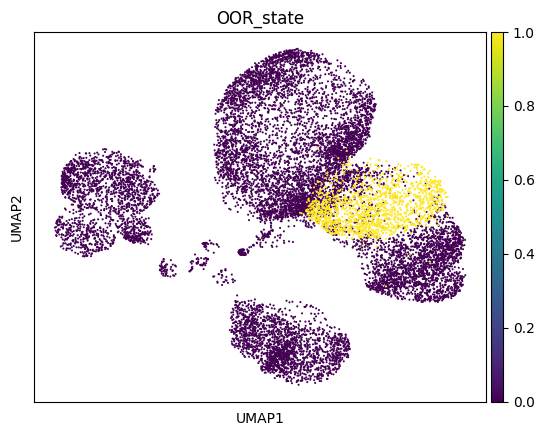

In [60]:
milopy.utils.build_nhood_graph(adata)
sc.pl.umap(adata, color=['OOR_state'] )

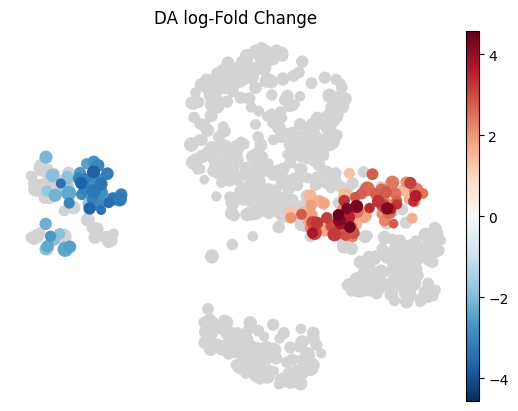

### Is mapping of subset of ctrl samples on model the same as mapping all ctrl samples on model?

In [89]:
## Load mapping of all ctrl samples
full_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
full_adata = sc.read_h5ad(full_dir + 'pac_design.h5ad', backed=True)

## Load mapping of subset of ctrl samples
subset_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/ctrl_size_analysis/ctrl_size5_seed12346/'
subset_adata = sc.read_h5ad(subset_dir + 'PAC_design.h5ad', backed=True)

full_adata = full_adata[subset_adata.obs_names[subset_adata.obs['is_ctrl'] == 1]]
subset_adata = subset_adata[subset_adata.obs['is_ctrl'] == 1]

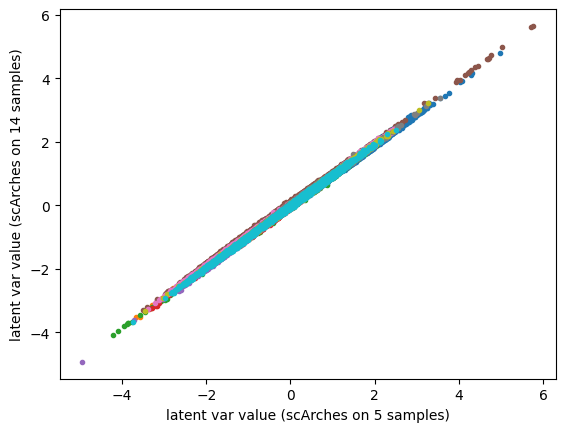

In [100]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(subset_adata.obsm['X_scVI'][:,i], full_adata.obsm['X_scVI'][:,i], '.');
    plt.xlabel('latent var value (scArches on 5 samples)');
    plt.ylabel('latent var value (scArches on 14 samples)');

In [ ]:
from oor_benchmark.methods.scArches_milo import run_milo
from oor_benchmark.api import check_dataset

In [105]:
oor_ct = 'natural_killer_cell'
full_dir = f'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/qPBMC_500cells_demo_perturb_cell_type{oor_ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
full_adata = sc.read_h5ad(full_dir + 'pac_design.h5ad')
full_adata.obs["Site"] = full_adata.obs.sample_id.str[0:4]

## Mark OOR state
if 'OOR_state' not in full_adata.obs:
    full_adata.obs['OOR_state'] = np.where(full_adata.obs[annotation_col] == oor_ct, 1, 0)

In [134]:
from oor_benchmark.methods.scArches_milo import run_milo
from oor_benchmark.api import check_dataset
from oor_benchmark.metrics.utils import make_OOR_per_group
from oor_benchmark.metrics.FDR_TPR_FPR import FDR_TPR_FPR
from oor_benchmark.metrics.auprc import auprc
import pandas as pd

In [135]:
def main(
    split_seed = 2022,
    n_controls = 5,
    diff_reference = 'ctrl',
    annotation_col = 'cell_type',
    sample_col = 'sample_id',
    signif_alpha = 0.1,
    control_site = True
    ):

    ## Select subset of ctrl samples
    disease_samples = full_adata.obs[full_adata.obs['is_ctrl'] == 0]['sample_id'].unique()
    ctrl_samples = full_adata.obs[full_adata.obs['is_ctrl'] == 1]['sample_id'].unique()

    np.random.seed(split_seed)
    ctrl_subsamples = np.random.choice(ctrl_samples, n_controls, replace=False)

    keep_samples = disease_samples.tolist() + ctrl_subsamples.tolist()
    adata_merge = full_adata[full_adata.obs.sample_id.isin(keep_samples)]
    adata_merge.obs['dataset_group'] = np.where(adata_merge.obs['is_ctrl'] == 1, 'ctrl', 'query')

    # n_controls = adata_merge[adata_merge.obs["dataset_group"] == diff_reference].obs[sample_col].unique().shape[0]
    n_querys = adata_merge[adata_merge.obs["dataset_group"] == "query"].obs[sample_col].unique().shape[0]
    sc.pp.neighbors(adata_merge, use_rep="X_scVI", n_neighbors=(n_controls + n_querys) * 5)
    
    if control_site:
        run_milo(adata_merge, "query", diff_reference, 
                 sample_col=sample_col, annotation_col=annotation_col,
                 design = '~Site+is_query'
                )
    else:
        run_milo(adata_merge, "query", diff_reference, 
                 sample_col=sample_col, annotation_col=annotation_col,
                 design = '~is_query'
                )

    sample_adata = adata_merge.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) & (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata_merge.obsm["nhoods"].T
    adata_merge.uns["sample_adata"] = sample_adata.copy()

    make_OOR_per_group(adata_merge)
    res_df = pd.concat([FDR_TPR_FPR(adata_merge), auprc(adata_merge)], 1)
    res_df['OOR_state'] = oor_ct
    res_df['n_ctrls'] = n_controls
    res_df['random_seed'] = split_seed
    return(res_df)

In [170]:
from oor_benchmark.api import _check_nonegative_integers_X
if not _check_nonegative_integers_X(full_adata)

False

In [136]:
import warnings
stability_res_df = pd.DataFrame()
for n in np.arange(5, 10):
    for s in 2022 + np.arange(5):
        print(f'# ctrls: {n}, seed: {s}')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            stability_res_df = pd.concat([stability_res_df, main(n_controls=n, split_seed=s)])

# ctrls: 5, seed: 2022
# ctrls: 5, seed: 2023
# ctrls: 5, seed: 2024
# ctrls: 5, seed: 2025
# ctrls: 5, seed: 2026
# ctrls: 6, seed: 2022
# ctrls: 6, seed: 2023
# ctrls: 6, seed: 2024
# ctrls: 6, seed: 2025
# ctrls: 6, seed: 2026
# ctrls: 7, seed: 2022
# ctrls: 7, seed: 2023
# ctrls: 7, seed: 2024
# ctrls: 7, seed: 2025
# ctrls: 7, seed: 2026
# ctrls: 8, seed: 2022
# ctrls: 8, seed: 2023
# ctrls: 8, seed: 2024
# ctrls: 8, seed: 2025
# ctrls: 8, seed: 2026
# ctrls: 9, seed: 2022
# ctrls: 9, seed: 2023
# ctrls: 9, seed: 2024
# ctrls: 9, seed: 2025
# ctrls: 9, seed: 2026


<AxesSubplot: xlabel='n_ctrls', ylabel='TPR'>

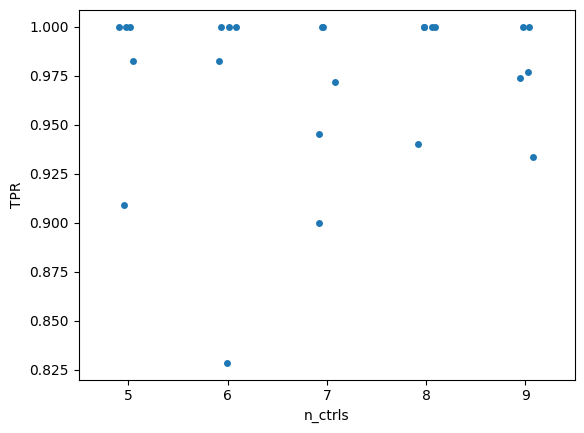

In [138]:
import seaborn as sns
sns.stripplot(data=stability_res_df, x='n_ctrls', y='TPR')

<AxesSubplot: xlabel='n_ctrls', ylabel='FDR'>

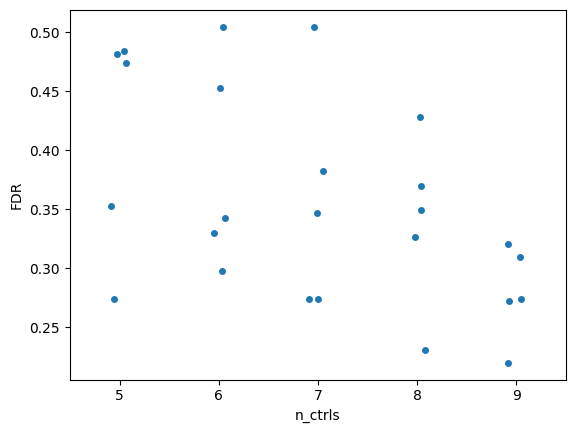

In [139]:
sns.stripplot(data=stability_res_df, x='n_ctrls', y='FDR')

In [140]:
## Without controlling for site of the dataset 
stability_nodesign_res_df = pd.DataFrame()
for n in np.arange(5, 10):
    for s in 2022 + np.arange(5):
        print(f'# ctrls: {n}, seed: {s}')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            stability_nodesign_res_df = pd.concat([
                stability_nodesign_res_df, main(n_controls=n, split_seed=s, control_site=False)], 0)

# ctrls: 5, seed: 2022
# ctrls: 5, seed: 2023
# ctrls: 5, seed: 2024
# ctrls: 5, seed: 2025
# ctrls: 5, seed: 2026
# ctrls: 6, seed: 2022
# ctrls: 6, seed: 2023
# ctrls: 6, seed: 2024
# ctrls: 6, seed: 2025
# ctrls: 6, seed: 2026
# ctrls: 7, seed: 2022
# ctrls: 7, seed: 2023
# ctrls: 7, seed: 2024
# ctrls: 7, seed: 2025
# ctrls: 7, seed: 2026
# ctrls: 8, seed: 2022
# ctrls: 8, seed: 2023
# ctrls: 8, seed: 2024
# ctrls: 8, seed: 2025
# ctrls: 8, seed: 2026
# ctrls: 9, seed: 2022
# ctrls: 9, seed: 2023
# ctrls: 9, seed: 2024
# ctrls: 9, seed: 2025
# ctrls: 9, seed: 2026


(0.0, 1.0)

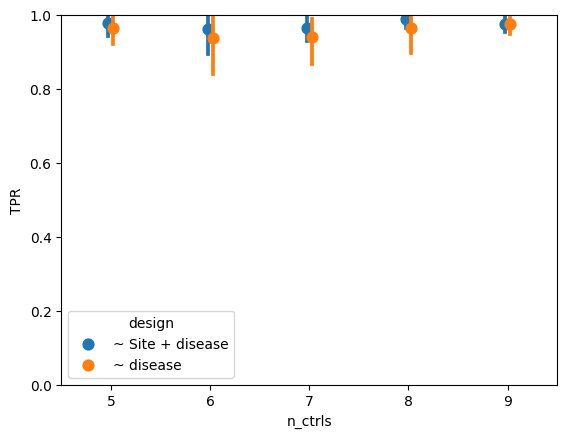

In [156]:
stability_nodesign_res_df['design'] = '~ disease'
stability_res_df['design'] = '~ Site + disease'
sns.pointplot(data=pd.concat([stability_res_df, stability_nodesign_res_df]), 
              x='n_ctrls', y='TPR', join=False, hue='design', dodge=True);
plt.ylim(0,1)
# sns.pointplot(data=stability_nodesign_res_df, x='n_ctrls', y='TPR', join=False, color='blue')

(0.0, 1.0)

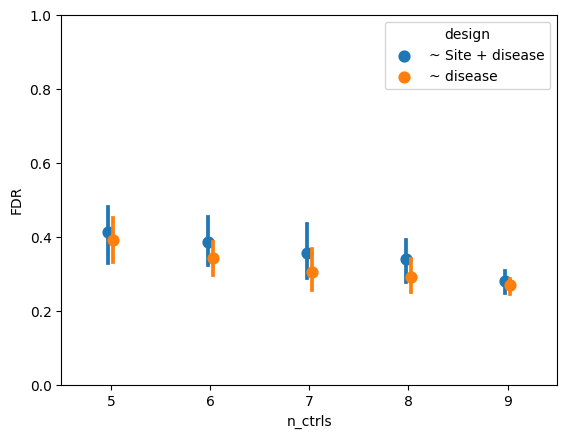

In [157]:
sns.pointplot(data=pd.concat([stability_res_df, stability_nodesign_res_df]), 
              x='n_ctrls', y='FDR', join=False, hue='design', dodge=True);
plt.ylim(0,1)

In [172]:
adata = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp//qPBMC_500cells_demo_perturb_cell_typecentral_memory_CD4_positive_alpha_beta_T_cell_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/model_ctrl/adata.h5ad')

In [295]:
sim_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp//qPBMC_500cells_demo_perturb_cell_typeplatelet_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'

In [296]:
random_seed=2022

In [297]:
# Make new dir for outputs
outdir = os.path.join(sim_dir, f'ctrl_size_analysis_nquery{n_querys}/')
if not os.path.exists(outdir):
    os.mkdir(outdir)

sim_id = 'ctrl_size{n_controls}_seed{random_seed}'.format(**locals())
outdir = outdir + sim_id + '/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [298]:
n_querys = 5
n_controls = 5

In [299]:
# Load query and control data
adata_merge = sc.read_h5ad(sim_dir + 'acr_design.h5ad')

# Control for collection site when subsampling controls in Stephenson
adata_merge.obs["Site"] = adata_merge.obs.donor_id.str[0:4]

# Subset query donors with most cells in query_specific population
oor_ct = adata_merge.obs[annotation_col][adata_merge.obs["OOR_state"] == 1][0]
disease_samples = adata_merge.obs[adata_merge.obs[annotation_col] == oor_ct].value_counts(
    'donor_id')[0:n_querys].index

In [294]:
np.random.seed(random_seed)
n_oor_cells_donor = adata_merge.obs[adata_merge.obs[annotation_col] == oor_ct].value_counts('donor_id') 
n_cells_donor = adata_merge.obs.value_counts('donor_id') 
# disease_samples = n_oor_cells_donor.index
disease_samples = (n_oor_cells_donor[n_oor_cells_donor > 0]/n_cells_donor[n_oor_cells_donor > 0]).sort_values(ascending=False)[0:n_querys].index

donor_id
CV0917         0.517103
CV0904         0.444000
CV0926         0.398000
newcastle65    0.351738
CV0911         0.284553
dtype: float64

In [269]:
# Subset control donors
np.random.seed(random_seed)
ctrl_samples = adata_merge.obs[adata_merge.obs['is_ctrl']
                               == 1]['donor_id'].unique()
ctrl_samples = np.random.choice(ctrl_samples, n_controls, replace=False)

keep_samples = disease_samples.tolist() + ctrl_samples.tolist()
adata_merge = adata_merge[adata_merge.obs.donor_id.isin(
    keep_samples)].copy()

In [270]:
adata_merge = adata_merge[adata_merge.obs.donor_id.isin(
    keep_samples)].copy()

## -- ACR design -- ##
acr_adata = adata_merge.copy()
sc.pp.neighbors(acr_adata, use_rep="X_scVI",
                n_neighbors=(n_controls + n_querys) * 5)
scArches_milo.run_milo(acr_adata, "query", 'ctrl',
                       annotation_col=annotation_col,
                       design='~Site+is_query'
                       )

## Harmonize output
sample_adata = acr_adata.uns["nhood_adata"].T.copy()
sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
sample_adata.var["OOR_signif"] = (
    ((sample_adata.var["SpatialFDR"] < signif_alpha) & (sample_adata.var["logFC"] > 0)).astype(int).copy()
)
sample_adata.varm["groups"] = acr_adata.obsm["nhoods"].T
acr_adata.uns["sample_adata"] = sample_adata.copy()

make_OOR_per_group(acr_adata)
acr_res_df = pd.concat([FDR_TPR_FPR(acr_adata), auprc(acr_adata)], 1)
acr_res_df['OOR_state'] = oor_ct
acr_res_df['n_ctrls'] = n_controls
acr_res_df['random_seed'] = random_seed
acr_res_df['ref_design'] = "ACR"
acr_res_df.to_csv(outdir + 'ACR_results.csv')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/tmp/ipykernel_727/275605294.py:23: FutureWarning: In a future v

In [275]:
sample_adata = acr_adata.uns['sample_adata'].copy()

In [277]:
sample_adata.var

,index_cell,kth_distance,nhood_annotation,nhood_annotation_frac,logFC,logCPM,F,PValue,FDR,SpatialFDR,OOR_score,OOR_signif,n_OOR_cells,frac_OOR_cells,OOR_state_group
0,10_1038_s41591_021_01329_2-BGCV01_GAAGCAGTCGCA...,1.589844,naive_thymus_derived_CD4_positive_alpha_beta_T...,0.822222,0.724254,11.890511,0.173786,0.677634,0.973630,0.967464,0.724254,0,21.0,0.238636,1
1,10_1038_s41591_021_01329_2-BGCV01_GGCTCGACACGC...,1.904313,mucosal_invariant_T_cell,0.666667,6.897041,11.379334,7.168694,0.008631,0.464269,0.460535,6.897041,0,59.0,0.921875,1
2,10_1038_s41591_021_01329_2-BGCV01_CCGTACTCACTC...,1.543612,naive_thymus_derived_CD4_positive_alpha_beta_T...,0.600000,1.854982,12.077207,1.322003,0.252889,0.918350,0.899455,1.854982,0,81.0,0.692308,1
3,10_1038_s41591_021_01329_2-BGCV01_CGATCGGAGGAT...,1.755697,effector_memory_CD8_positive_alpha_beta_T_cell,0.500000,2.360434,11.660029,1.479204,0.226672,0.918350,0.899455,2.360434,0,22.0,0.278481,1
4,10_1038_s41591_021_01329_2-BGCV01_CAAGATCCAAGA...,2.047612,natural_killer_cell,0.769231,1.122317,11.786103,0.397789,0.529577,0.963934,0.947126,1.122317,0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,10_1038_s41591_021_01329_2-TCTCTAAAGATGCCTT-ne...,2.019217,mucosal_invariant_T_cell,0.361111,-0.676172,11.541432,0.183660,0.669139,0.973630,0.967464,-0.676172,0,16.0,0.242424,1
339,10_1038_s41591_021_01329_2-CGCTTCAAGAGAGCTC-ne...,1.669926,effector_memory_CD8_positive_alpha_beta_T_cell,0.922330,-2.996005,12.355065,4.519456,0.035895,0.578657,0.574880,-2.996005,0,0.0,0.000000,0
340,10_1038_s41591_021_01329_2-GACTAACCAGTGGAGT-ne...,1.956609,naive_thymus_derived_CD4_positive_alpha_beta_T...,0.714286,-1.317402,11.535994,0.734587,0.393385,0.918350,0.899455,-1.317402,0,15.0,0.223881,1
341,10_1038_s41591_021_01329_2-TCGCGAGTCCGTTGTC-ne...,1.852971,CD14_low_CD16_positive_monocyte,0.982456,5.132370,11.655410,2.668456,0.105400,0.875819,0.858548,5.132370,0,0.0,0.000000,0


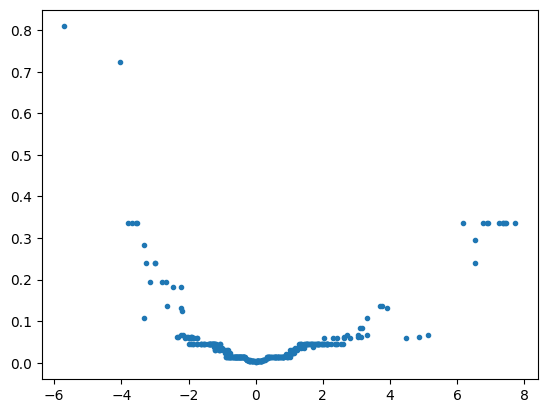

In [280]:
plt.plot(sample_adata.var["OOR_score"], - np.log10(sample_adata.var["SpatialFDR"]), '.')

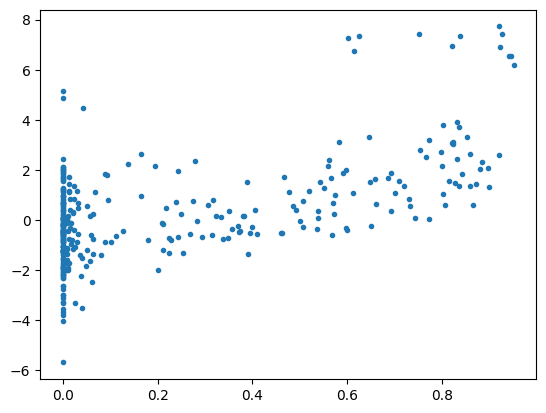

In [279]:
plt.plot(sample_adata.var["frac_OOR_cells"], sample_adata.var["OOR_score"], '.')

In [300]:
adata_merge = milopy.utils.read_milo_adata(sim_dir + 'acr_design.h5ad')
sc.tl.umap(adata_merge)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


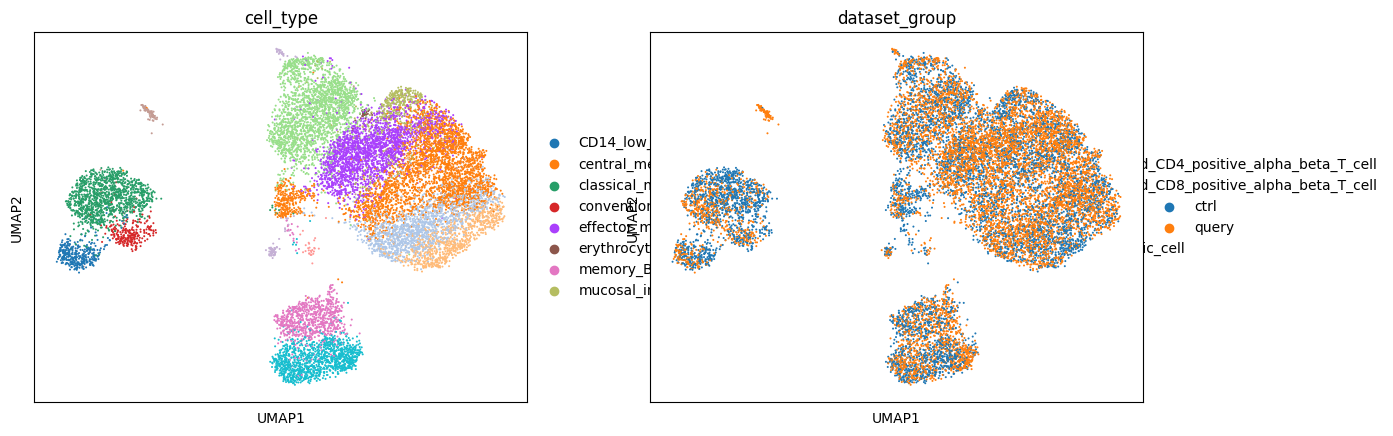

In [304]:
sc.pl.umap(adata_merge, color=[ 'cell_type', 'dataset_group'])

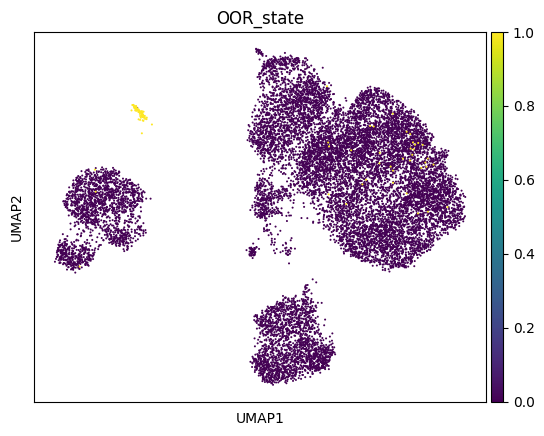

In [305]:
sc.pl.umap(adata_merge, color=['OOR_state'])

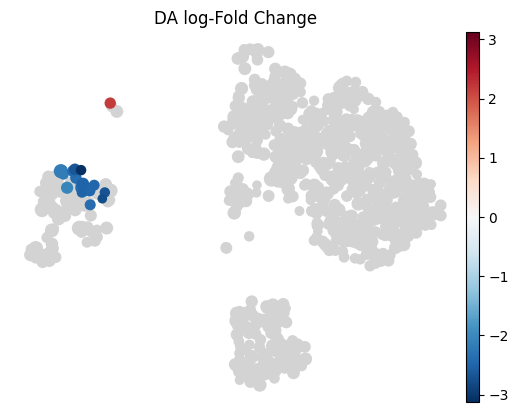

In [306]:
import milopy
milopy.utils.build_nhood_graph(adata_merge)
milopy.plot.plot_nhood_graph(adata_merge, min_size=1)

In [310]:
n_cells = 600000
round((20000 / n_cells) * 400)

13